In [560]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bau-ari5004-fall23-a2p1/sample_submission.csv
/kaggle/input/bau-ari5004-fall23-a2p1/train.csv
/kaggle/input/bau-ari5004-fall23-a2p1/test.csv
/kaggle/input/bau-ari5004-fall23-a2p1/images/images/slide_POZZ__img_F0X0.jpeg
/kaggle/input/bau-ari5004-fall23-a2p1/images/images/slide_XV1T__img_HCML.jpeg
/kaggle/input/bau-ari5004-fall23-a2p1/images/images/slide_Z7EQ__img_JMV6.jpeg
/kaggle/input/bau-ari5004-fall23-a2p1/images/images/slide_BB06__img_XK43.jpeg
/kaggle/input/bau-ari5004-fall23-a2p1/images/images/slide_ZCFK__img_OHA2.jpeg
/kaggle/input/bau-ari5004-fall23-a2p1/images/images/slide_7GWR__img_K1E1.jpeg
/kaggle/input/bau-ari5004-fall23-a2p1/images/images/slide_YWOV__img_T0H2.jpeg
/kaggle/input/bau-ari5004-fall23-a2p1/images/images/slide_ZHW1__img_NA9V.jpeg
/kaggle/input/bau-ari5004-fall23-a2p1/images/images/slide_REPD__img_VXC2.jpeg
/kaggle/input/bau-ari5004-fall23-a2p1/images/images/slide_Y3LZ__img_EL2V.jpeg
/kaggle/input/bau-ari5004-fall23-a2p1/images/images/slide_8IXU__i

In [561]:
train_data=pd.read_csv('/kaggle/input/bau-ari5004-fall23-a2p1/train.csv')
test_data=pd.read_csv('/kaggle/input/bau-ari5004-fall23-a2p1/test.csv')

In [562]:
train_data.head()

,img_id,label
0,slide_02PR__img_0U9O,0
1,slide_02PR__img_C2PC,0
2,slide_02PR__img_NZQ5,0
3,slide_02PR__img_U8ZC,0
4,slide_02PR__img_WD8I,0


In [563]:
train_data.describe()

,label
count,1399.000000
mean,0.598999
std,0.490276
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [564]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   img_id  1399 non-null   object
 1   label   1399 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 22.0+ KB


In [565]:
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import os

class CustomDataset(Dataset):
    def __init__(self, csv_file, image_folder, transform=None, mode='train'):
        self.data = pd.read_csv(csv_file)
        self.image_folder = image_folder
        self.transform = transform
        self.mode = mode  # 'train' or 'test'

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, f"{self.data.iloc[idx, 0]}.jpeg")
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        if self.mode == 'train':
            label = self.data.iloc[idx, 1]
            return image, label
        else:  # For test mode
            img_id = str(self.data.iloc[idx, 0])
            return image, img_id



In [566]:
import os
import pandas as pd
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import transforms
from PIL import Image

# Define the paths
train_csv_path = '/kaggle/input/bau-ari5004-fall23-a2p1/train.csv'
test_csv_path = '/kaggle/input/bau-ari5004-fall23-a2p1/test.csv'
image_folder_path = '/kaggle/input/bau-ari5004-fall23-a2p1/images/images'

# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create datasets
train_dataset = CustomDataset(csv_file=train_csv_path, image_folder=image_folder_path, transform=train_transform)
val_dataset = CustomDataset(csv_file=train_csv_path, image_folder=image_folder_path, transform=val_transform)
test_dataset = CustomDataset(csv_file=test_csv_path, image_folder=image_folder_path, transform=val_transform, mode='test')

# Split the dataset into training and validation sets
val_split = 0.2
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(val_split * dataset_size)

train_indices, val_indices = indices[split:], indices[:split]

# Create data loaders using SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=32, sampler=val_sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [567]:
test_loader

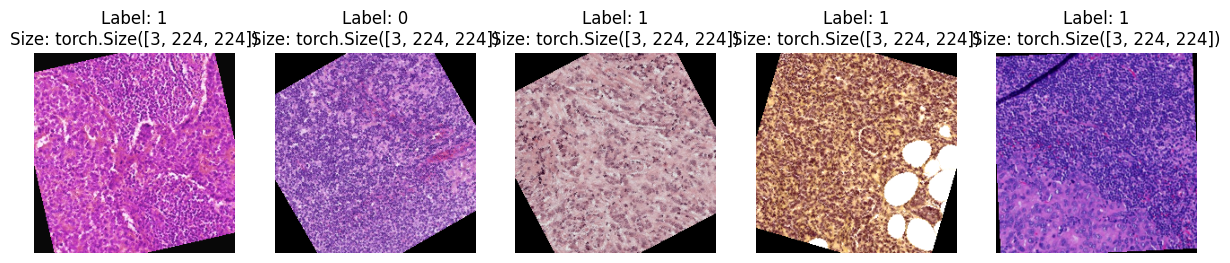

In [568]:
import matplotlib.pyplot as plt
import numpy as np

# Get some random samples from the training dataset
num_samples = 5
random_indices = np.random.randint(0, len(train_dataset), num_samples)

# Plot the images
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

for i, idx in enumerate(random_indices):
    image, label = train_dataset[idx]
    image_size = image.size()  # Get the size of the image
    image = image.permute(1, 2, 0)
    axes[i].imshow(image)
    axes[i].set_title(f"Label: {label}\nSize: {image_size}")
    axes[i].axis('off')

plt.show()


In [569]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [570]:
#Creating the model 
from torch import nn 
class CancerClassifier(nn.Module):
    def __init__(self, input_shape: int,hidden_units: list, output_shape: int) -> None:
        super().__init__()
        

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units[0], 
                      kernel_size=3, 
                      stride=1, 
                      padding=1), 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units[0], 
                      out_channels=hidden_units[0],
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2), 
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units[0], hidden_units[1], kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units[1], hidden_units[1], kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units[1] * 56 * 56,
                      out_features=hidden_units[2]),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units[2],
                      out_features=output_shape),
        )

    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

torch.manual_seed(42)
model = CancerClassifier(input_shape=3, 
                  hidden_units=[256, 128, 64], 
                  output_shape=2).to(device)
model

CancerClassifier(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=401408, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [571]:
#Setting loss and optimizer 
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [572]:
import torch.nn.functional as F
# Training loop
num_epochs = 150
for epoch in range(num_epochs):
    model.train()  
    train_loss = 0.0
    
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        # Forward pass
        y_pred = model(X)
        # Convert y to one-hot encoded format
        y_one_hot = F.one_hot(y, num_classes=2).float()
    
        # Calculate the binary cross-entropy loss
        loss = loss_fn(y_pred, y_one_hot)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    # Print the average training loss for the epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss / len(train_loader)}")

Epoch 1/150, Training Loss: 0.8802153536251613
Epoch 2/150, Training Loss: 0.6797864368983677
Epoch 3/150, Training Loss: 0.6660739915711539
Epoch 4/150, Training Loss: 0.6292538097926549
Epoch 5/150, Training Loss: 0.6104294691767012
Epoch 6/150, Training Loss: 0.5848211305482047
Epoch 7/150, Training Loss: 0.564141550234386
Epoch 8/150, Training Loss: 0.5789279997348785
Epoch 9/150, Training Loss: 0.541601346220289
Epoch 10/150, Training Loss: 0.5501331124986921
Epoch 11/150, Training Loss: 0.5017996770995004
Epoch 12/150, Training Loss: 0.4798789509705135
Epoch 13/150, Training Loss: 0.4876559053148542
Epoch 14/150, Training Loss: 0.5220226407051086
Epoch 15/150, Training Loss: 0.49134509563446044
Epoch 16/150, Training Loss: 0.4681623135294233
Epoch 17/150, Training Loss: 0.4726924159697124
Epoch 18/150, Training Loss: 0.4647403708526066
Epoch 19/150, Training Loss: 0.46214306609971184
Epoch 20/150, Training Loss: 0.4688265860080719
Epoch 21/150, Training Loss: 0.4329839084829603
E

In [573]:
from sklearn.metrics import roc_auc_score
import numpy as np



# Set the model in evaluation mode
model.eval()

# Initialize lists for true labels and predicted probabilities
all_true_labels = []
all_pred_probs = []

# Initialize the validation loss
val_loss = 0.0

# Iterate over the validation data
with torch.no_grad():  
    for X_val, y_val in val_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)

        # Forward pass
        y_val_pred = model(X_val)
        # Convert y_val to one-hot encoded format
        y_val_one_hot = F.one_hot(y_val, num_classes=2).float()

        # Calculate the binary cross-entropy loss
        loss_val = loss_fn(y_val_pred, y_val_one_hot)

        # Accumulate the validation loss
        val_loss += loss_val.item()

        # Convert predicted probabilities to numpy array
        pred_probs = F.softmax(y_val_pred, dim=1)[:, 1].cpu().numpy()

        # Accumulate true labels and predicted probabilities
        all_true_labels.extend(y_val.cpu().numpy())
        all_pred_probs.extend(pred_probs)

# Calculate average validation loss
average_val_loss = val_loss / len(val_loader)

# Convert lists to numpy arrays for AUROC calculation
true_labels_array = np.array(all_true_labels)
pred_probs_array = np.array(all_pred_probs)

# Calculate AUROC
auroc = roc_auc_score(true_labels_array, pred_probs_array)

print(f"Average Validation Loss: {average_val_loss:.4f}")
print(f"AUROC: {auroc:.4f}")


Average Validation Loss: 0.3245
AUROC: 0.9311


In [589]:
from sklearn.metrics import roc_auc_score

all_image_ids = []
all_cancer_scores = []

with torch.no_grad():
    for batch in test_loader:
        X_test, *image_ids = batch  # Unpack the elements of the batch
        X_test = X_test.to(device)  # Assuming the image data is in the first element of the batch

        # Ensure image_ids is a list of strings
        image_ids = [str(id) for id in image_ids[0]]

        # Forward pass
        y_test_pred = model(X_test)

        # Calculate predicted probabilities for the cancer class
        cancer_scores = F.softmax(y_test_pred, dim=1)[:, 1].cpu().numpy()

        # Accumulate image IDs and cancer scores
        all_image_ids.extend(image_ids)
        all_cancer_scores.extend(cancer_scores)  # Extend the list instead of appending

# Convert image IDs and cancer scores to a DataFrame
submission_df = pd.DataFrame({'img_id': all_image_ids, 'cancer_score': all_cancer_scores})

# Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)




# Display the first few rows of the submission DataFrame
print(submission_df.head())
submission_df.info()




                 img_id  cancer_score
0  slide_0DLO__img_BDDJ  2.824868e-06
1  slide_0EDV__img_6JPH  9.999982e-01
2  slide_0EDV__img_CZIU  2.794642e-01
3  slide_0EDV__img_X46B  1.301368e-08
4  slide_0G1L__img_WD2F  3.746514e-03
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 938 entries, 0 to 937
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   img_id        938 non-null    object 
 1   cancer_score  938 non-null    float32
dtypes: float32(1), object(1)
memory usage: 11.1+ KB
